<img src='../00_common/figures/iaeaheader.svg' style='width:100%'/>
<p style="font-size:2em;padding-bottom: 0.5em; font-weight: bold;">
<em>E-learning course on <br / ><br / >
Advanced Neutron Imaging</em>
</p> 

# Measuring the resolution in an image
Anders Kaestner, Laboratory for Neutron Scattering and Imaging, Paul Scherrer Institut, 2022

<img src='../00_common/figures/by-nc-nd.svg' style='height:30px'/>

## What you will learn in this tutorial

### Introduction
The resolution tells the highest spatial frequency you can unambiguously observe in the image. It has an upper limit set by the sampling frequency, but is mostly less. Lower spatial frequencies appear as smooth edges in the image. 

The resolution is a consequence of a series of optical components in your imaging system (penumbra blurring, scintillator, lens, and camera) it could in principle also involve the effect of filtering you applied to the image.

$$h_{system} = h_{penumbra} * h_{scintillator} * h_{lens} * h_{camera} * h_{filters}$$

### Needed mathematical concepts
- Convolution 
- Fourier transform
- Curve fitting
- Interpolation

#### We need some module for the tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import tifffile as tiff
import matplotlib.patches as mpatches
import skimage.filters as flt
import sys

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

if "google.colab" in sys.modules:
    # Running on colab we need to download repos from github
    !rm -rf scripts
    !rm -rf QuantifyingNeutronImages
    !git clone https://github.com/ImagingELearning/resolution.git
    !git clone https://github.com/neutronimaging/scripts.git
    data_path="/content/resolution/tutorials/00_common/data/"
    sys.path.append("/content/scripts/python")
else: 
    # Running locally on your computer
    data_path = "../00_common/data/"
    sys.path.append('../00_common/')

import resolutiontools as res

%config InlineBackend.figure_format = 'retina'

In [2]:
import importlib
importlib.reload(res)

<module 'resolutiontools' from '/Users/kaestner/lectures/resolution/tutorials/03_Resolution/../00_common/resolutiontools.py'>

## The principle to measuring the resolution
The resolution can be measured using two main methods
- Using test patterns representing discrete resolutions
- Measuring the width intensity spread from an absorbing edge

<figure>

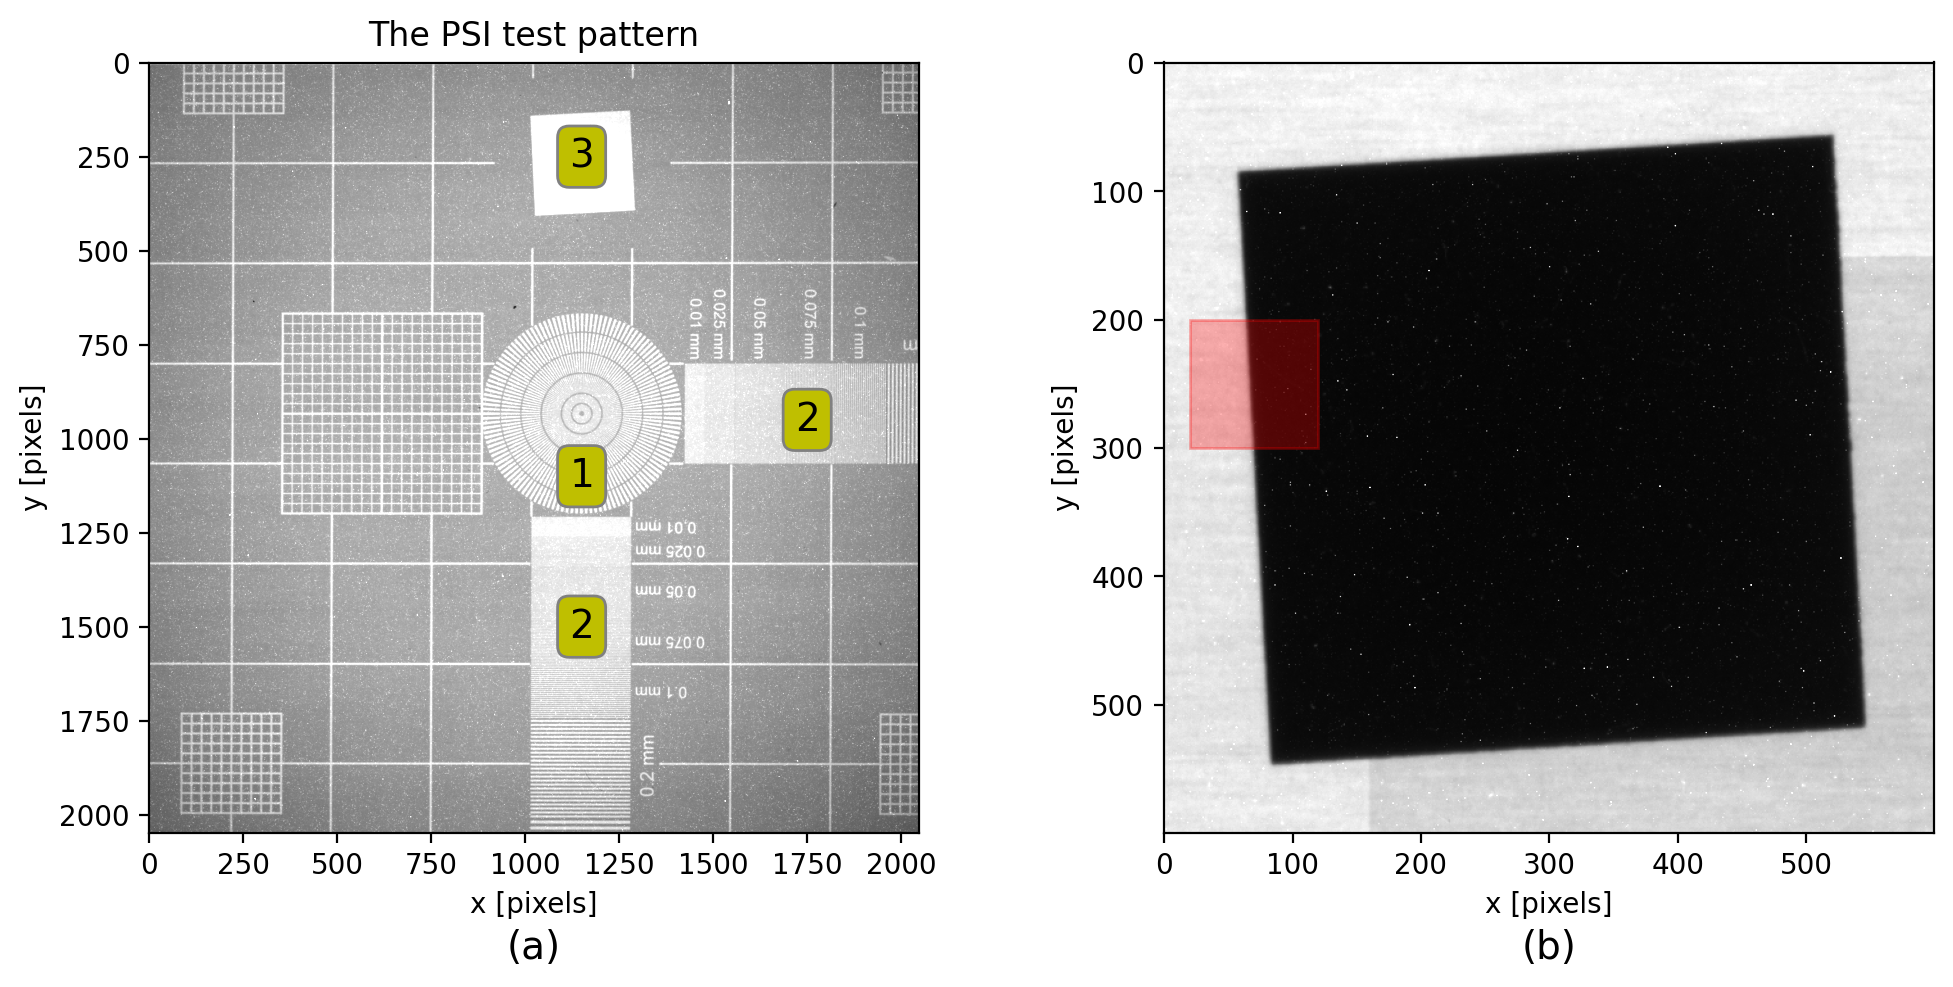

In [3]:
# Visualization - code to show and annotate the figure
fig,ax = plt.subplots(1,2,figsize=(12,5))
img1 = tiff.imread('../00_common/data/edges/edge20mm_0000.tif')

idx_edge    = 1
idx_pattern = 0
ax[idx_edge].imshow(img1,vmin=300,vmax=30000,cmap='gray');
ax[idx_edge].set_xlabel('x [pixels]')
ax[idx_edge].set_ylabel('y [pixels]');
rect=mpatches.Rectangle((20,200),100,100,fc='r',ec='r',alpha=0.3)
ax[idx_edge].add_patch(rect)

img2 = fits.getdata('data/focus_34mm_60s.fits')
ax[idx_pattern].imshow(img2,vmin=800,vmax=10000,cmap='gray')
ax[idx_pattern].set_title('The PSI test pattern')
bbox_props = dict(boxstyle="round", fc="y", ec="0.5", alpha=1.0)
ax[idx_pattern].text(1150,1100, "1", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[idx_pattern].text(1150,1500, "2", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[idx_pattern].text(1750,950, "2", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[idx_pattern].text(1150,250, "3", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[idx_pattern].set_xlabel('x [pixels]')
ax[idx_pattern].set_ylabel('y [pixels]');

fontsize=14
labelposition= -0.15
# Set label for panel 1 -> (a)
ax[0].text(0.5, labelposition, '(a)', transform=ax[0].transAxes, fontsize=fontsize, ha='center',va='center')  


# Set label for panel 2 -> (b)
ax[1].text(0.5, labelposition, '(b)', transform=ax[1].transAxes, fontsize=fontsize, ha='center',va='center') ; 

<figcaption align = "center"><b>Figure 1</b> - Items to measure the resolution; (a) a printed test pattern and (b) knife edge made of gadolinum (for neutrons)</figcaption>
</figure>

Figure 1 shows two devices that can be used to measure the resolution. Panel (a) shows a segment of a test pattern device with different features to measure the resolution. 
1. __Siemens star__: The spatial frequeny of the spokes in decrease as function of the radius. 
2. __Line patterns__: Blocks of parallel line with given spatial frequency.
3. Straight absorbing edges.

The item in panel (b) is an absorbing item with straight edges. The region marked with a red rectangle will later be used to measure the resolution.

## Measuring the resolution using test patterns

The test pattern method is limited to the spatial frequencies avaliable in the test pattern.

<figure>

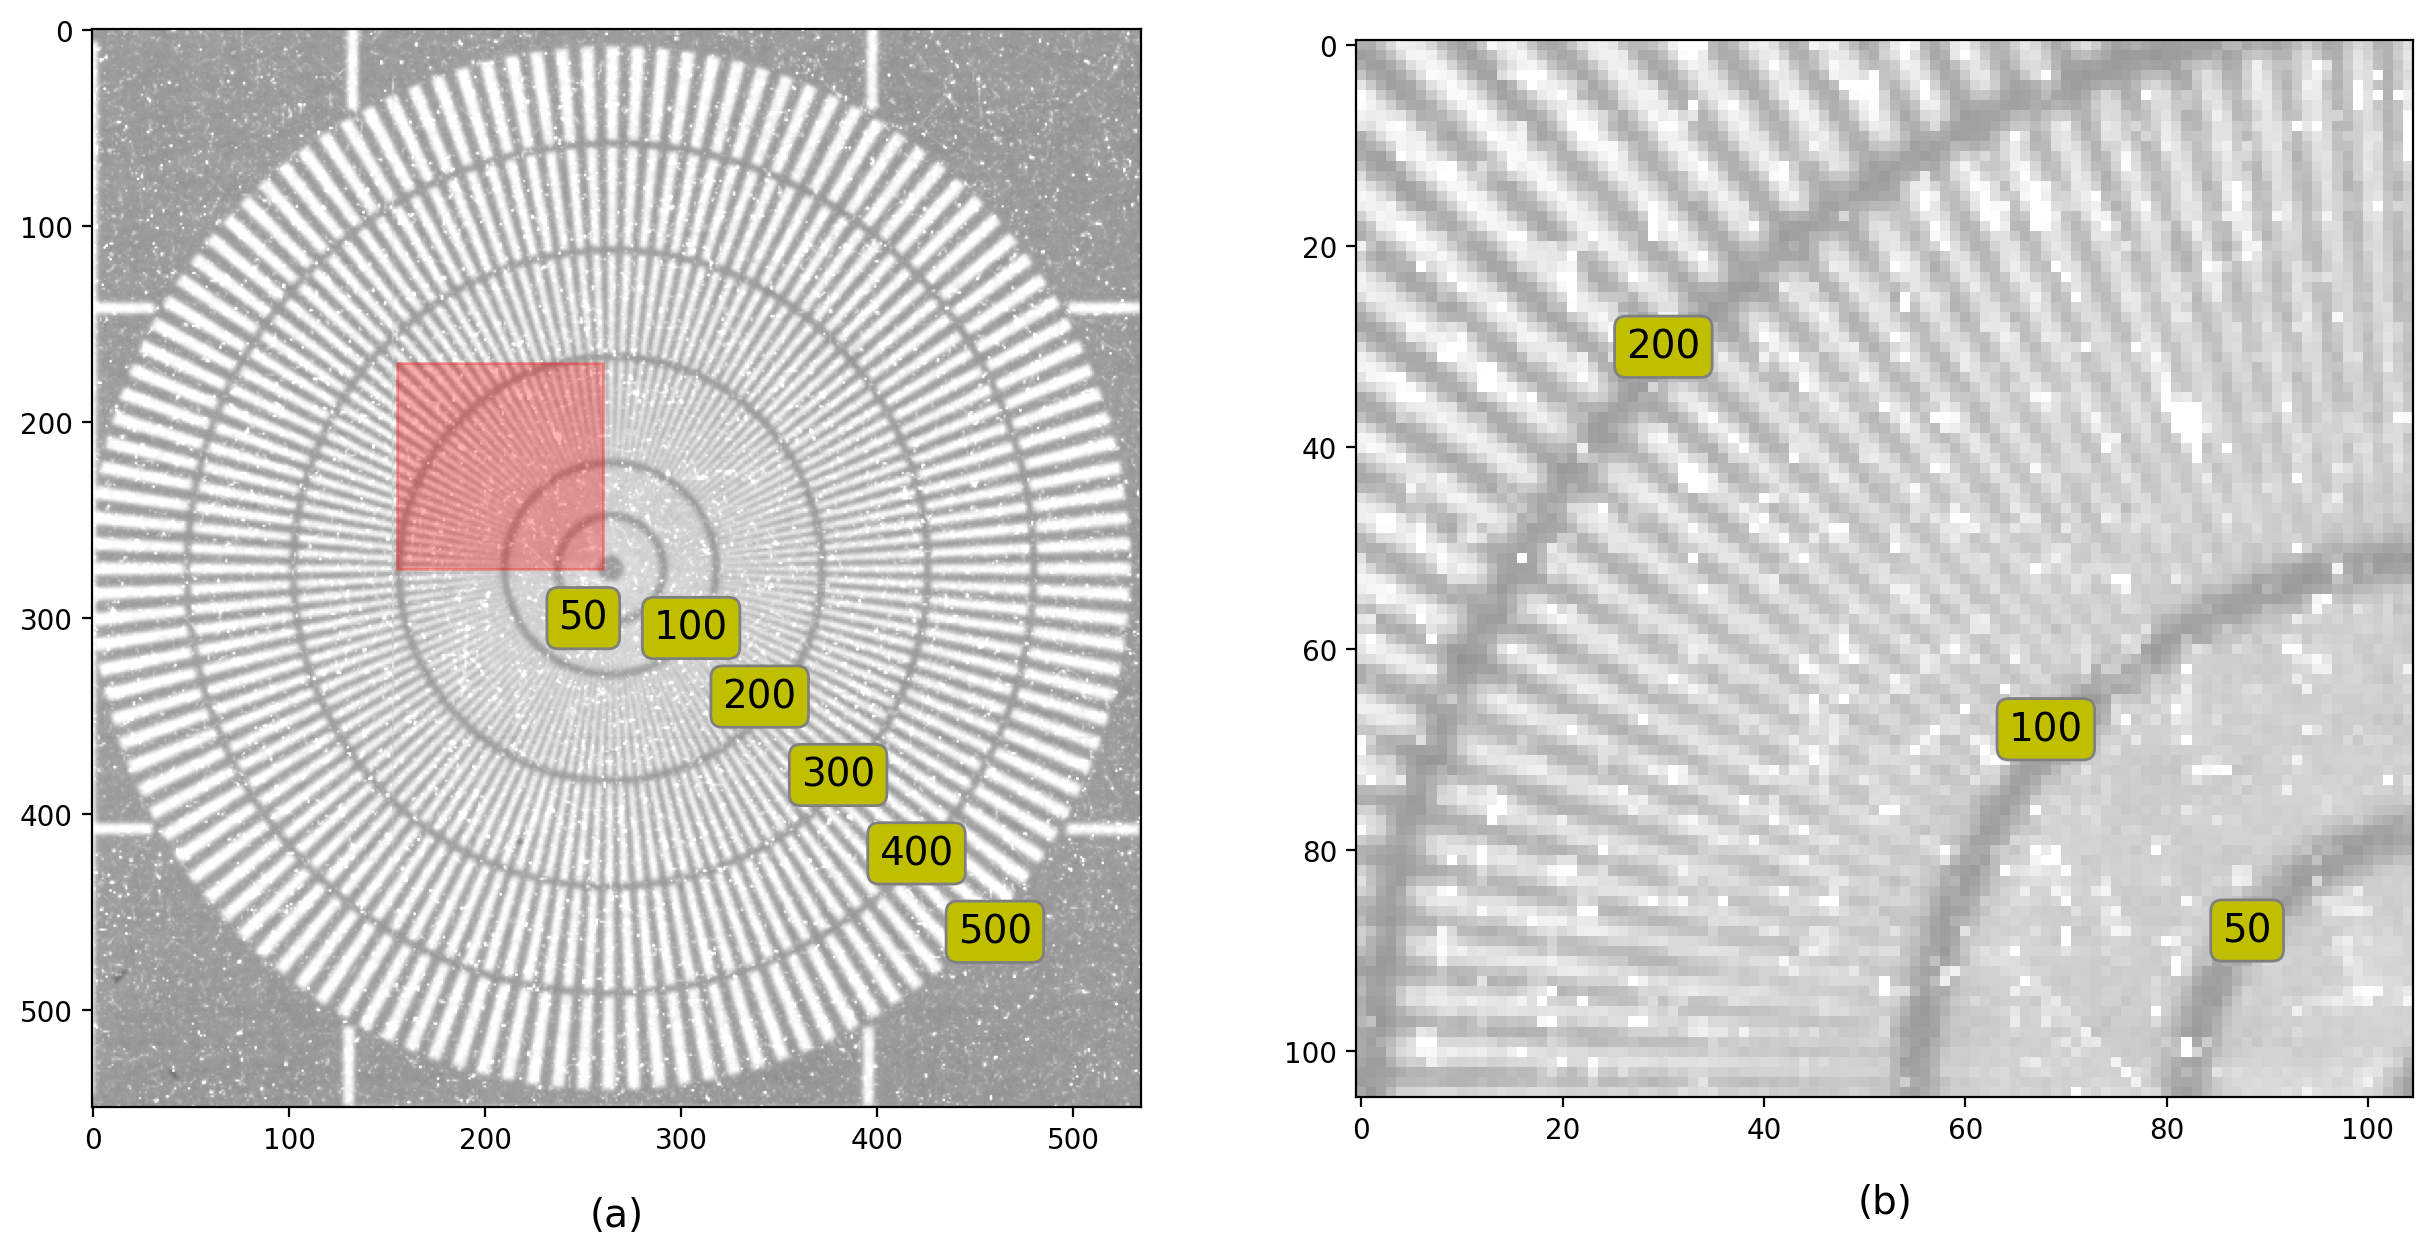

In [4]:
# Visualization - code to show and annotate the figures
fig,ax=plt.subplots(1,2,figsize=(15,7))
im=img2[660:1210,885:1420]
ax[0].imshow(im,vmin=800,vmax=11000,cmap='gray')
rect=mpatches.Rectangle((155,170),105,105,fc='r',ec='r',alpha=0.3)
ax[0].add_patch(rect)

bbox_props = dict(boxstyle="round", fc="y", ec="0.5", alpha=1.0)
ax[0].text(460,460, "500", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[0].text(420,420, "400", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[0].text(380,380, "300", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[0].text(340,340, "200", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[0].text(305,305, "100", ha="center", va="center", size=14,
        bbox=bbox_props)
#ax[0].text(342,340, "50", ha="center", va="center", size=14,
 #       bbox=bbox_props)
ax[0].text(250,300, "50", ha="center", va="center", size=14,
         bbox=bbox_props)
#ax[1].imshow(img2[840:935,1040:1150] ,vmin=800,vmax=10000,cmap='gray');
ax[1].imshow(im[170:275,155:260] ,vmin=800,vmax=11000,cmap='gray');
ax[1].text(30,30, "200", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[1].text(68,68, "100", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[1].text(88,88, "50", ha="center", va="center", size=14,
        bbox=bbox_props)

fontsize=14
labelposition= -0.1
# Set label for panel 1 -> (a)
ax[0].text(0.5, labelposition, '(a)', transform=ax[0].transAxes, fontsize=fontsize, ha='center',va='center')  


# Set label for panel 2 -> (b)
ax[1].text(0.5, labelposition, '(b)', transform=ax[1].transAxes, fontsize=fontsize, ha='center',va='center') ; 

<figcaption align = "center"><b>Figure 2</b> - The PSI Siemens star resolution pattern (a). The resolution is found where the spokes cannot be resolved anymore (b).</figcaption>
</figure>

The Siemens star has spokes that grow wider the further away from the center they are. This results in increasing spatial frequencies closer to the center of the object. The rings that intersect the spokes indicate different spatial frequencies. One cycle requires a dark and a bright spoke, thus the spoke width for period 100$\mu$m is 50$\mu$m. The Siemens star is mostly used as a qualitative rough estimate of the resolution. There are however image analytical approaches to find the resolution more precise from the Siemens star as well.

<figure>

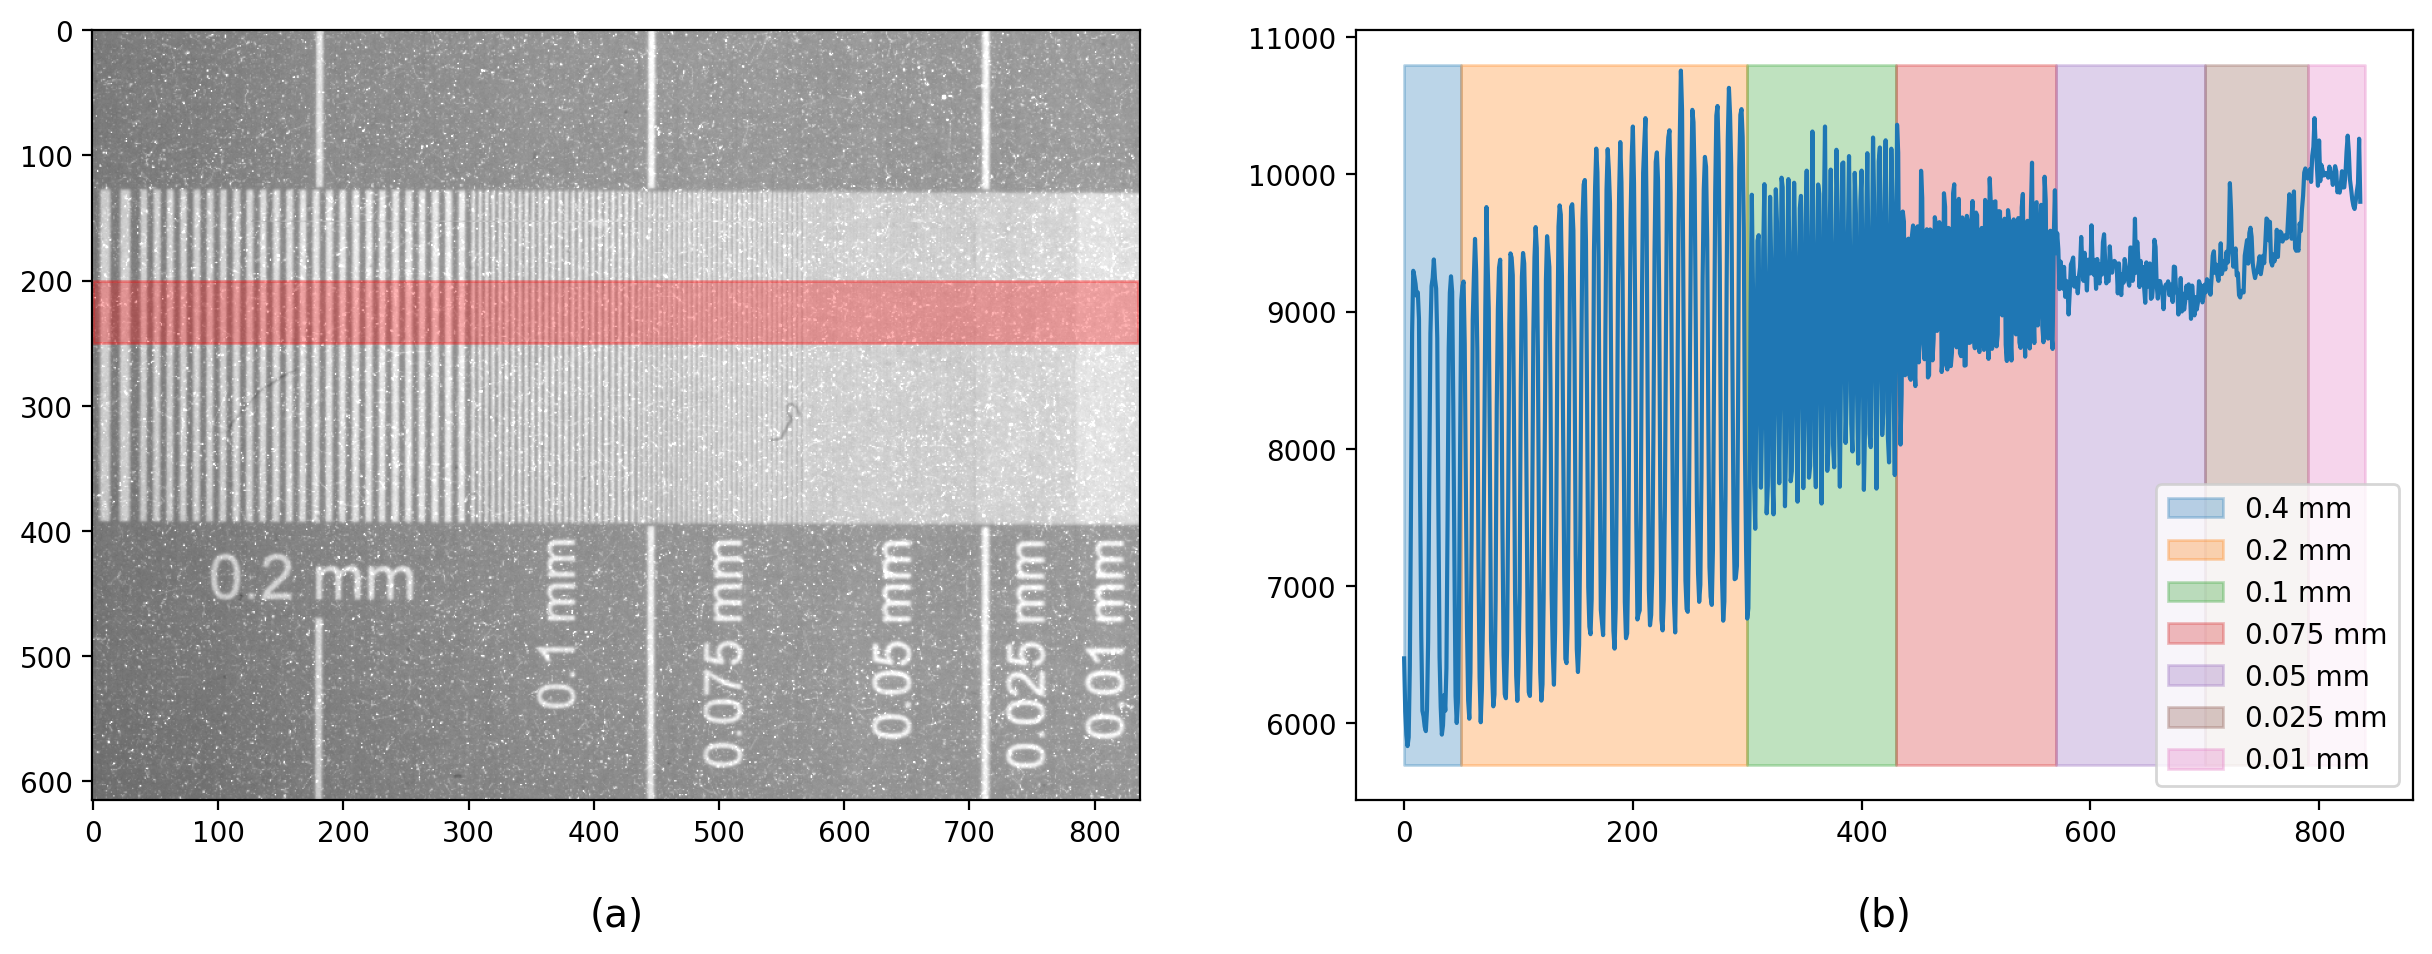

In [5]:
# Visualization - code to show and annotate the figure
fig,ax=plt.subplots(1,2,figsize=(15,5))
im=np.transpose(img2[1210:,885:1500])[:,-1:0:-1]
ax[0].imshow(im,vmin=800,vmax=11000,cmap='gray')
rect=mpatches.Rectangle((0,200),835,50,fc='r',ec='r',alpha=0.3)
ax[0].add_patch(rect)
ax[1].plot(im[200:250,:].mean(axis=0))
ymin=5700
ymax=10800
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

ax[1].fill_between(x=[0,50]  ,  y1=[ymin,ymin],y2=[ymax,ymax],color=colors[0],alpha=0.3,label='0.4 mm');
ax[1].fill_between(x=[50,300],  y1=[ymin,ymin],y2=[ymax,ymax],color=colors[1],alpha=0.3,label='0.2 mm');
ax[1].fill_between(x=[300,430], y1=[ymin,ymin],y2=[ymax,ymax],color=colors[2],alpha=0.3,label='0.1 mm');
ax[1].fill_between(x=[430,570], y1=[ymin,ymin],y2=[ymax,ymax],color=colors[3],alpha=0.3,label='0.075 mm');
ax[1].fill_between(x=[570,700], y1=[ymin,ymin],y2=[ymax,ymax],color=colors[4],alpha=0.3,label='0.05 mm');
ax[1].fill_between(x=[700,790], y1=[ymin,ymin],y2=[ymax,ymax],color=colors[5],alpha=0.3,label='0.025 mm');
ax[1].fill_between(x=[790,840], y1=[ymin,ymin],y2=[ymax,ymax],color=colors[6],alpha=0.3,label='0.01 mm');
ax[1].legend()

fontsize=14
labelposition= -0.15
# Set label for panel 1 -> (a)
ax[0].text(0.5, labelposition, '(a)', transform=ax[0].transAxes, fontsize=fontsize, ha='center',va='center')  


# Set label for panel 2 -> (b)
ax[1].text(0.5, labelposition, '(b)', transform=ax[1].transAxes, fontsize=fontsize, ha='center',va='center') ; 


<figcaption align = "center"><b>Figure 3</b> - Line patterns (a). Horizontal average profile (b).</figcaption>
</figure>

The line pattern in figure 3 has segments with piecewise constant period. The resolution can only be determined to one of the provided periods. It can be difficult to visually determine the resolution. A method to find the resolution is to make a profile over all line blocks, e.g. using a average profile from the red region in figure 3a. A such profile is shown in 3b. Here, we can see that the 75$\mu$m block still delivers a strong signal while the 50$\mu$m block barely show a signal. The higher resolution block only show the nonsense from aliasing as these are not even supported by the pixel size of the image.

## Measuring the resolution using edge spread
The method of measuring resolution using is based on the extracting the intensity profile across a high contrast sharp edge. The ideal material to produce such an edge in neutron imaging is gadolinium that thanks to its high attenuation coefficient allows the use of a thin sheet. The reason for using a thin sheet is that it can lead to errors in the measurement in case the test object is not perfectly perpendicular to the beam. A deviation will add unsharpnes to the measurement due to different material thicknesses as shown in the figure below.

<br/>
<figure>
<img src="figures/materialthickness.svg" style="width:400px"/>
<br/>  
<figcaption align = "center"><b>Figure 4</b> - Edge response with different material thickness may bias the resolution measurements.</figcaption>
</figure>    
<br/>

The test object should also be slightly rotated (3-6$^{\circ}$) in the image plane to provide a slanted edge to allow better edge sampling. The figure below shows the profiles across different positions along the edge. Here, you can see that the shape varies slightly depending on where the profile is extracted.

<figure>

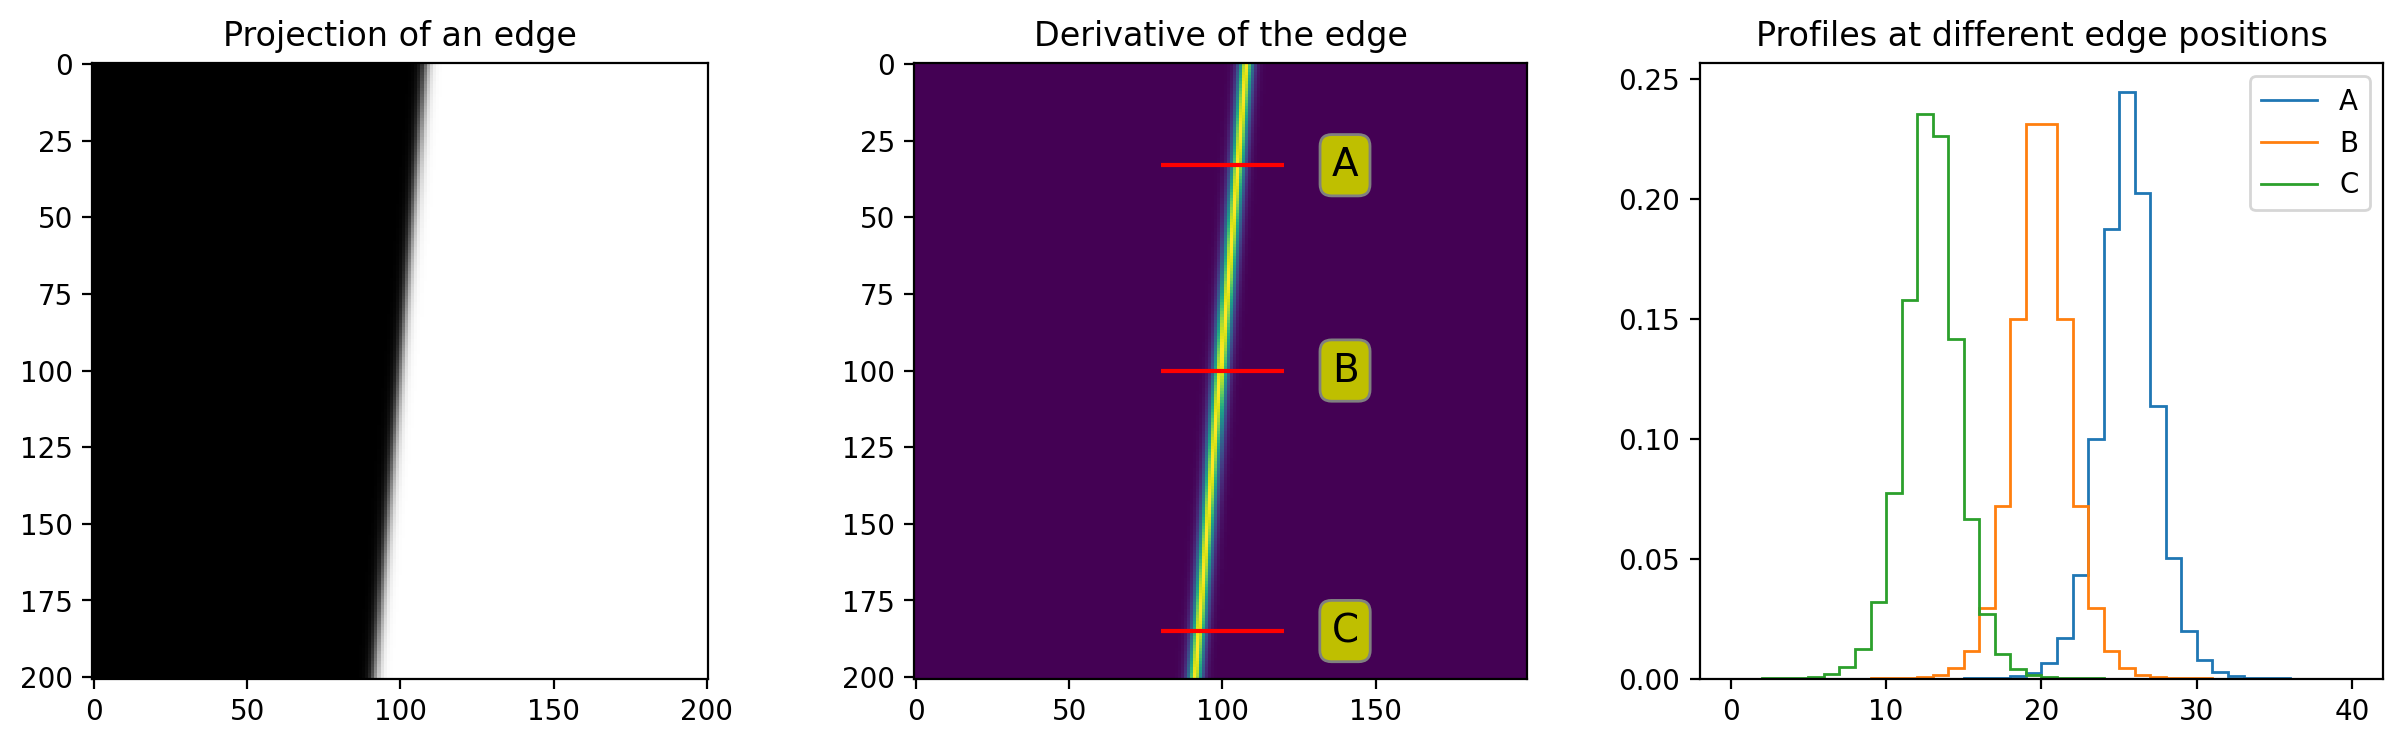

In [6]:
# This code is mainly to produce the figure to demonstrate the sampling problems with rotated patterns.
# You can look at it if you want, but understanding it is not essential for the explained phenomenon.
x,y = np.meshgrid(np.linspace(-10,10,201),np.linspace(-10,10,201))
def sigm(x,s) :
    return 1/(1+np.exp(-x/s))

e = sigm(x+0.0834*y,0.1)
de = np.diff(e)
fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].imshow(e,cmap='gray')
ax[0].set_title('Projection of an edge')
ax[1].imshow(de)
ax[1].set_title('Derivative of the edge')
begin=80
end=120
alpha=1
a = 33
b = 100
c = 185

ax[1].hlines([a,b,c],xmin=begin,xmax=end,color='red')
bbox_props = dict(boxstyle="round", fc="y", ec="0.5", alpha=1.0)
ax[1].text(end+20,a, "A", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[1].text(end+20,b, "B", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[1].text(end+20,c, "C", ha="center", va="center", size=14,
        bbox=bbox_props)

pA = de[a, begin:end]
pB = de[b,begin:end]
pC = de[c,begin:end]


ax[2].stairs(pA,label='A',alpha=alpha)
ax[2].stairs(pB,label='B',alpha=alpha)
ax[2].stairs(pC,label='C',alpha=alpha)
ax[2].legend()
ax[2].set_title('Profiles at different edge positions');

<figcaption align = "center"><b>Figure 5</b> - An edge and its profiles. The profile shape varies with the position.</figcaption>
</figure>

### Measuring line patterns and edges with better accuracy
In the previous section it was suggested to compute the average profile. This is done to improve the SNR of the profile. It is, however, important to draw the region perpendicular to the line pattern or the edge if an edge spread is foreseen. The reason is that an incorrect alignment will produce an under estimated resolution.

Let's first take a look at the average profile of an edge.

<figure>

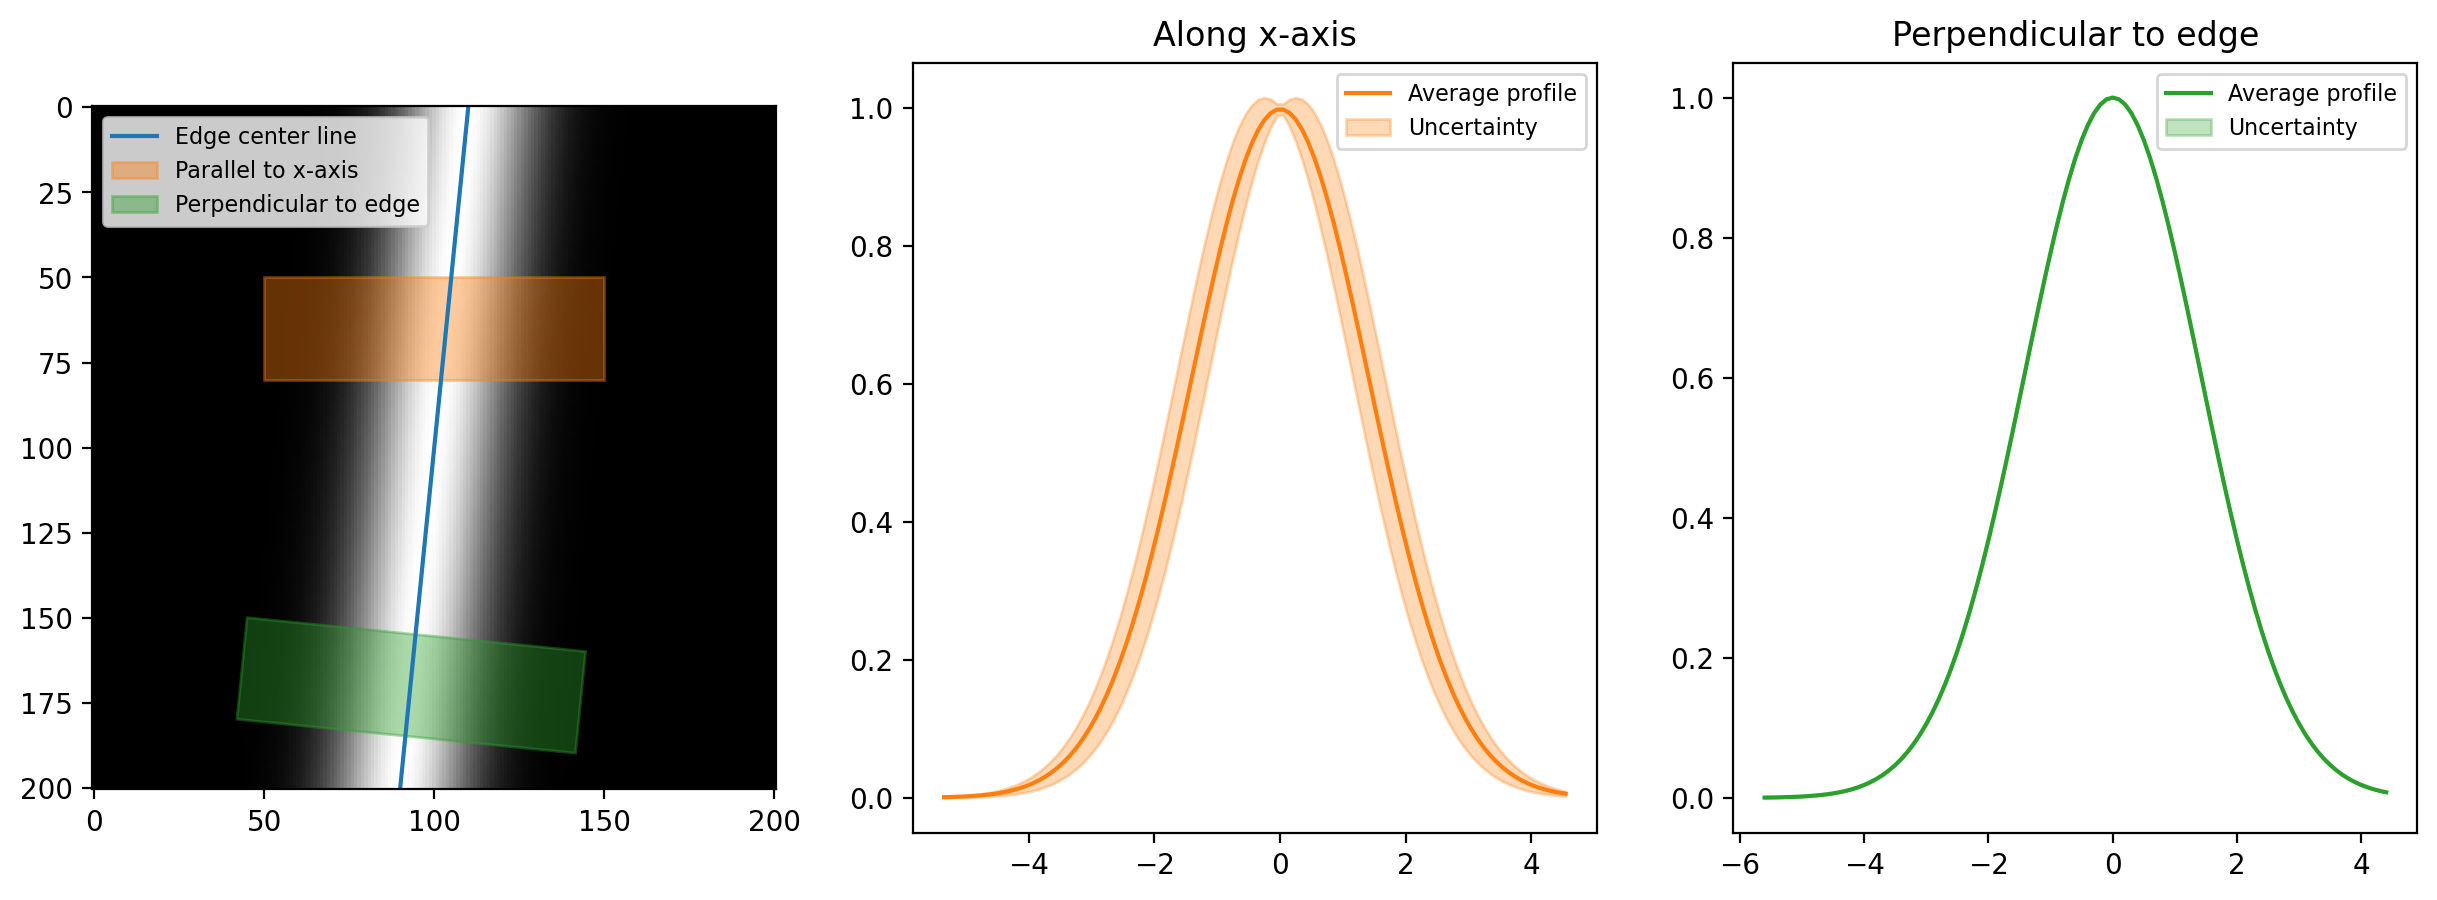

In [7]:
# This code is mainly to produce the figure to demonstrate the sampling problems with the slanted edge.
# You can look at it if you want, but understanding it is not essential for the explained phenomenon.
y2=x+0.1*y
g=np.exp(-y2**2/4)

fig,ax = plt.subplots(1,3,figsize=[15,5])
ax[0].imshow(g,cmap='gray')
ax[0].plot([90,110],[200,0],label='Edge center line');
rect0=mpatches.Rectangle((50,50),100,30,fc=colors[1],ec=colors[1],alpha=0.4, label='Parallel to x-axis')
ax[0].add_patch(rect0);
rect1=mpatches.Rectangle((45,150),100,30,fc=colors[2],ec=colors[2],alpha=0.4,angle=180*np.arctan(0.1)/np.pi,label='Perpendicular to edge')
ax[0].add_patch(rect1);
ax[0].legend(fontsize=8,loc='upper left')

m=g[50:80,50:150].mean(axis=0)
s=g[50:80,50:150].std(axis=0)
ax[1].plot(y2[65,50:150],m,color=colors[1], label='Average profile')
ax[1].fill_between(y2[65,50:150],y1=m-3*s,y2=m+3*s,color=colors[1], label='Uncertainty',alpha=0.3);
ax[1].set_title('Along x-axis')
ax[1].legend(fontsize=8)

yy2=np.unique(np.round(y2[95:105,45:145]*10)/10)
m2 = np.zeros(len(yy2))
s2 = np.zeros(len(yy2))
for idx,xx in enumerate(yy2) :
    m2[idx]=g[y2==xx].mean()
    s2[idx]=g[y2==xx].std()
ax[2].plot(yy2,m2,color=colors[2], label='Average profile')
ax[2].fill_between(yy2,y1=m2-3*s2,y2=m2+3*s2,color=colors[2], label='Uncertainty',alpha=0.3);
ax[2].set_title('Perpendicular to edge')
ax[2].legend(fontsize=8);

<figcaption align = "center"><b>Figure 6</b> - A closer look into the sampling of a slanted edge. You can reduce the uncertainty by sampling the line profile perpendicular to the line.</figcaption>
</figure>

Figure 6 shows the importance of sampling the edge perpendicular to the edge instead of just marking a rectangular ROI parallel to the image grid. The rectangular ROI introduces an uncertainty in the measurement due to the shifted edge position from line to line. The perpendicular measurement doesn't introduce this error. We will look into the edge extraction from a real edge in the next section.

<figure>

It is also important to pay attention to the orientation of the line pattern. Here, the effect of using a rectangular ROI can be more severe than with the edge. The example below show a model of a slightly smoothed line pattern. The first pattern is parallel the image axes, while the second is rotated by 5$^{\circ}$. The rotation should give better sampling of the pattern, but can lead to an under estimated resolution if the profile is measured incorrectly.

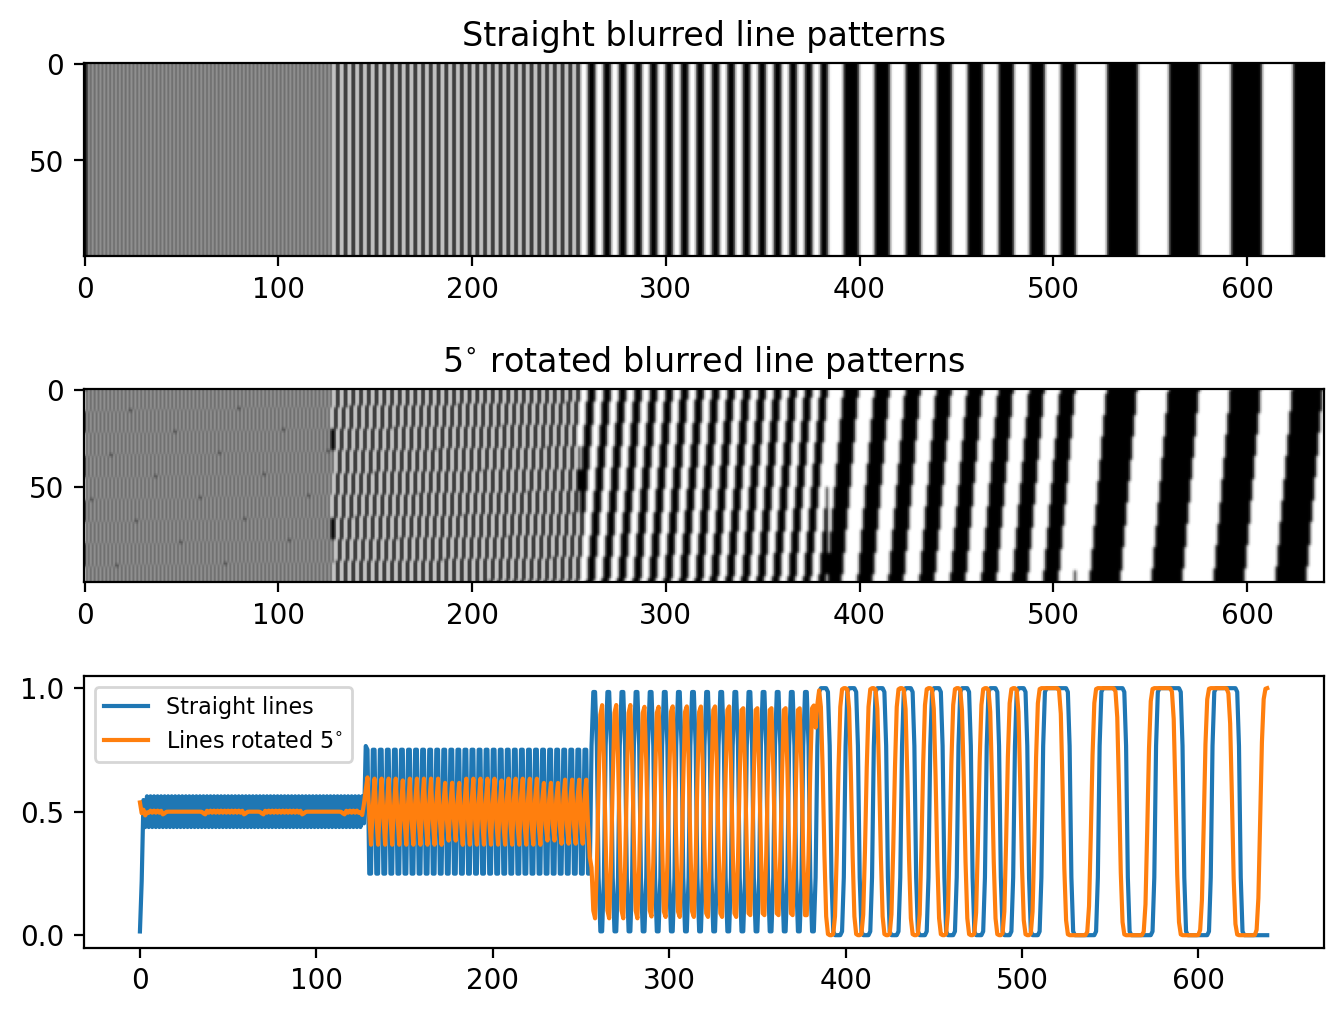

In [8]:
# This code is mainly to produce the figure to demonstrate the sampling problems with rotated patterns.
# You can look at it if you want, but understanding it is not essential for the explained phenomenon.
p   = np.array([2,4,8,16,32])
pp  = np.repeat(p,128)
x,y = np.meshgrid(np.linspace(0,len(pp),len(pp)),np.linspace(0,len(pp),len(pp)))
s   = 0.75
lines  = flt.gaussian((np.sin(2*np.pi/pp*x))[:100,:]>0,s)
rlines = flt.gaussian((np.sin(2*np.pi/pp*(x+np.tan(5/180*np.pi)*y)))[:100,:]>0,s)

# Visualization
fig,ax=plt.subplots(3,1,figsize=[8,6])
ax=ax.ravel()
ax[0].imshow(lines,cmap='gray')
ax[0].set_title('Straight blurred line patterns')
ax[1].imshow(rlines,cmap='gray')
ax[1].set_title('5$^{\circ}$ rotated blurred line patterns')
ax[2].plot(lines[30:60].mean(axis=0),label='Straight lines')
ax[2].plot(rlines[30:60].mean(axis=0),label='Lines rotated 5$^{\circ}$')
ax[2].legend(fontsize=8,loc='upper left');

<figcaption align = "center"><b>Figure 7</b> - Sampling errors with a rotated line pattern.</figcaption>
</figure>

The tapering of the straigt line profile (blue) is to be expected as a consequence of the blurring caused by the system resolution. The profile from the rotated pattern does however taper much stronger as an effect of the averaging over several image rows. At some point, one or more periods a included in the average which result in a constant average in the region. This effect can also be observerd in the low refquency part to the right. If you look closely, you can observe that the slope is not as steep as with the straight pattern. A further effect is that the observed profile period increases slightly. The increase is $1/\cos(5^{\circ})$, i.e. 0.5%, in our case.

The simple method to avoid this effect is to reduce the number of rows in the average. The more precise method is to use a rotated ROI that is perpendicular to the line pattern.

### Extracting a line spread profile from an edge image
We need to sample several positions along the edge to take advantage of the slanted edge and even achive subpixel accuracy. This must be done carefully using the distance to the edge. There are different methods to do the edge extraction. Among others thresholding and using the distance transform. Here, we will use the method described in the pixel size tutorial to fit a straight line to the edge and compute the average intensity at each distance from the edge.

In [10]:
from scipy.signal import savgol_filter as savgol
x = img1[200:300,20:120]

p,pos = res.edgeProfile(flt.median(x),decimals=1)
dp    = -savgol(p,21,2,1) # computes the derivative of the edge (the sign is only to flip the curve the falling edge case)

Here, we useed the edge profile extraction function from the pixel size tutorial and the [Savizky-Golay](https://en.wikipedia.org/wiki/Savitzky–Golay_filter) filter to compute the derivative that corresponds to the line spread function. The line spread function will be used to quantify the resolution of the image.

<figure>

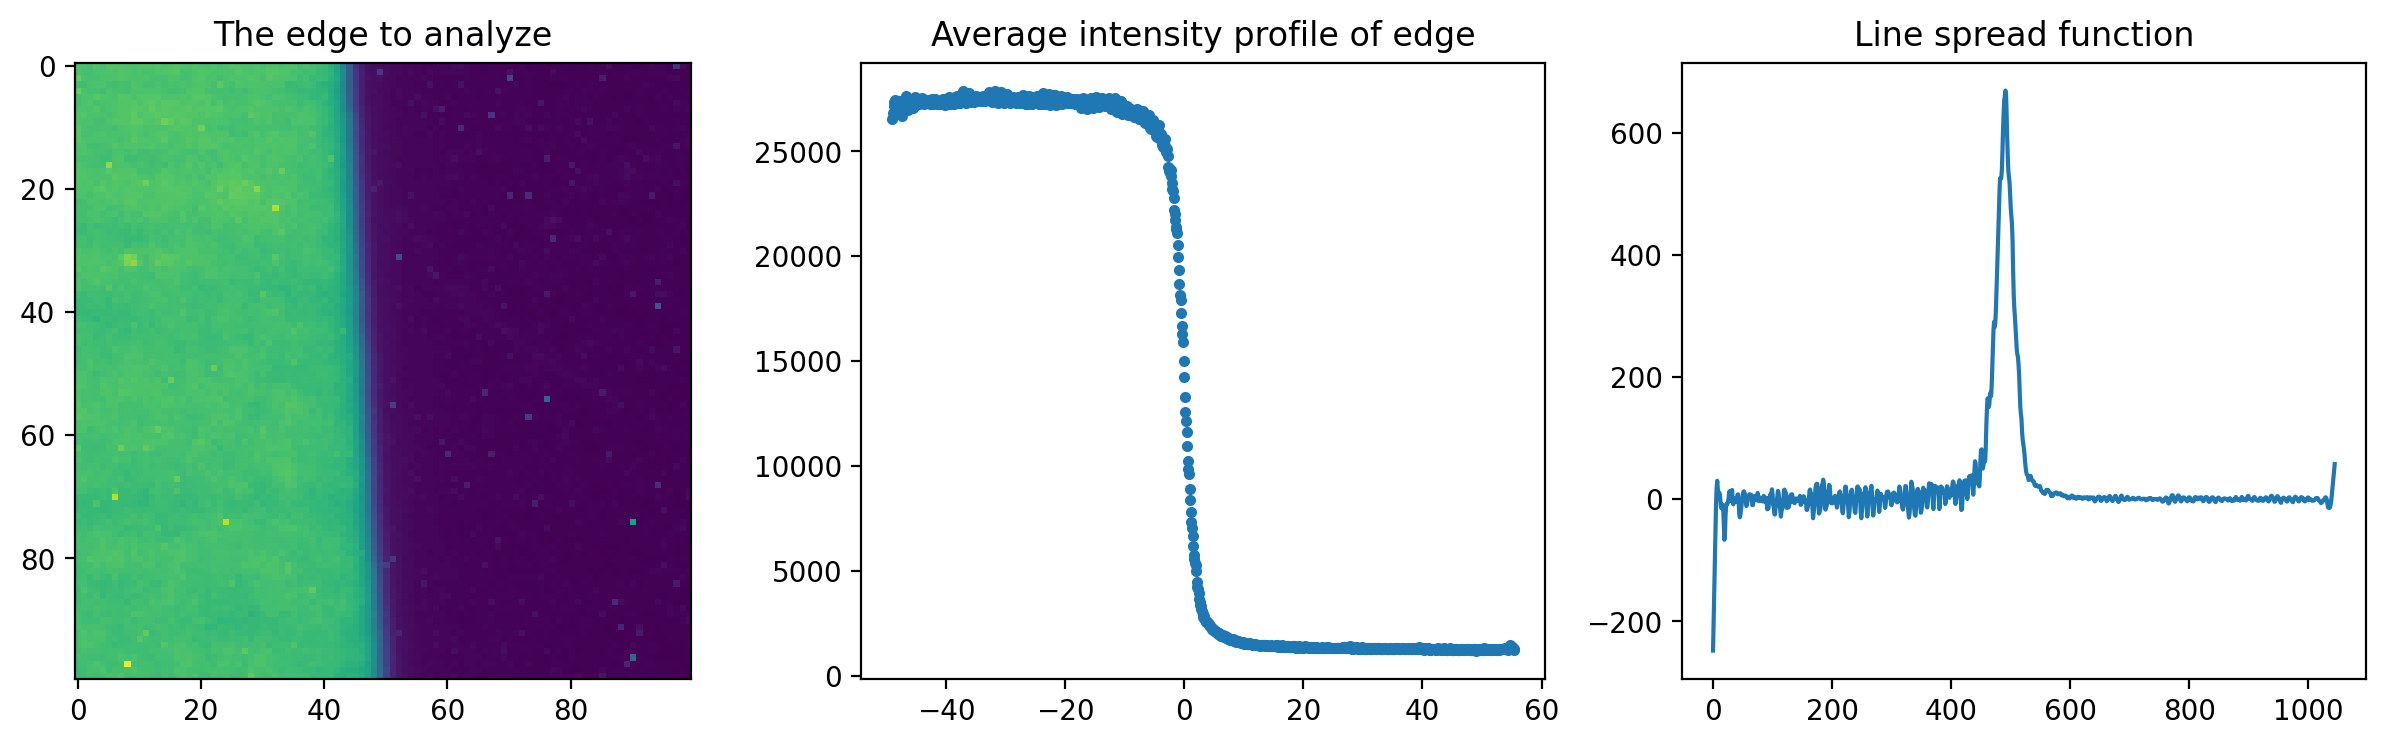

In [11]:
# Visualization of the profiles
fig,ax = plt.subplots(1,3,figsize=(15,4))
ax=ax.ravel()
ax[0].imshow(x)
ax[0].set_title('The edge to analyze')
ax[1].plot(pos,p,'.')
ax[1].set_title('Average intensity profile of edge')
ax[2].plot(-savgol(p,11,2,1));
ax[2].set_title('Line spread function');

<figcaption align = "center"><b>Figure 8</b> - The edge profile from figure 1b.</figcaption>
</figure>

The line spread function is still on a discrete grid, which leads to less precise measurements. Therefore, we now fit the profile points to two different functions that are used to describe the line spread; the Gaussian and the [Voight](https://en.wikipedia.org/wiki/Voigt_profile) function. These fitting functions are already defined in the resolution tools package provided with this tutorial. The fitting is done using the ```curve_fit``` function from scipy.

In [12]:
from scipy.optimize import curve_fit

vc, cov  = curve_fit(res.V2, pos, dp, p0=[1,1,0,4000])
gc, cov  = curve_fit(res.G2, pos, dp, p0=[1,0,4000])

<figure>

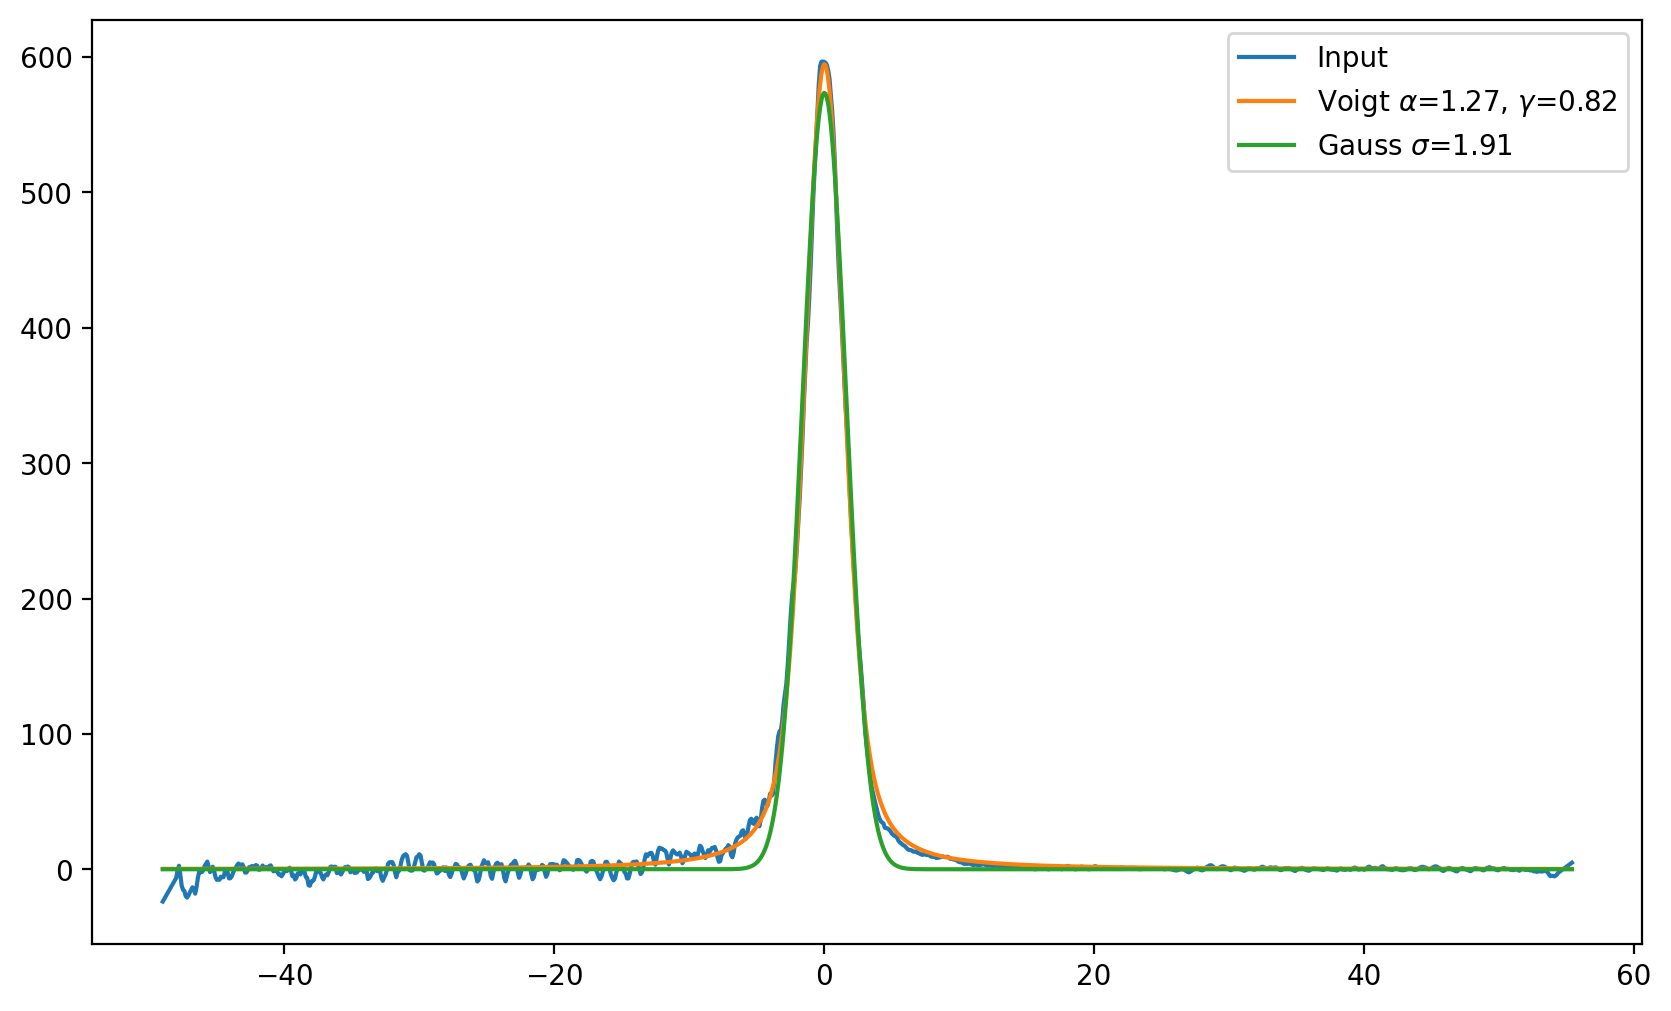

In [59]:
# Visualization of the profiles
fig,ax=plt.subplots(1,figsize=(10,6))
ax.plot(pos,dp,label='Input')
ax.plot(pos,res.V2(pos,vc[0],vc[1],vc[2],vc[3]),label=r'Voigt $\alpha$={0:0.2f}, $\gamma$={1:0.2f}'.format(vc[0],vc[1]))
ax.plot(pos,res.G2(pos,gc[0],gc[1],gc[2]),label='Gauss $\sigma$={0:0.2f}'.format(gc[0]))
ax.legend();

<figcaption align = "center"><b>Figure 9</b> - Fitting Gaussian and Voigt functions to the line spread function.</figcaption>
</figure>

In figure 9, you can see that the Voigt function does a better job in fitting the profile data and should be prefered over the Gaussian. The Voigt profile fits both the profile maximum and the tails better, in the mid-section of the peak the two models are comparable. The main motivation for using the Gaussian is it simplicity compared to the Voigt function.

### Resolution using full width half maximum (FWHM)
A frequently used method to measure the resolution from the line spread function is to use the so called _Full Width Half Maximum_ method. The priciple is of the method is described by its name; you measure the width of the edge spread function the position of the half height of the profile, see figure 10a. 

<figure>

In [ ]:
x=np.linspace(-10,10,201)
y=np.exp(-x**2/2)
hw=np.sqrt(2*np.log(2))

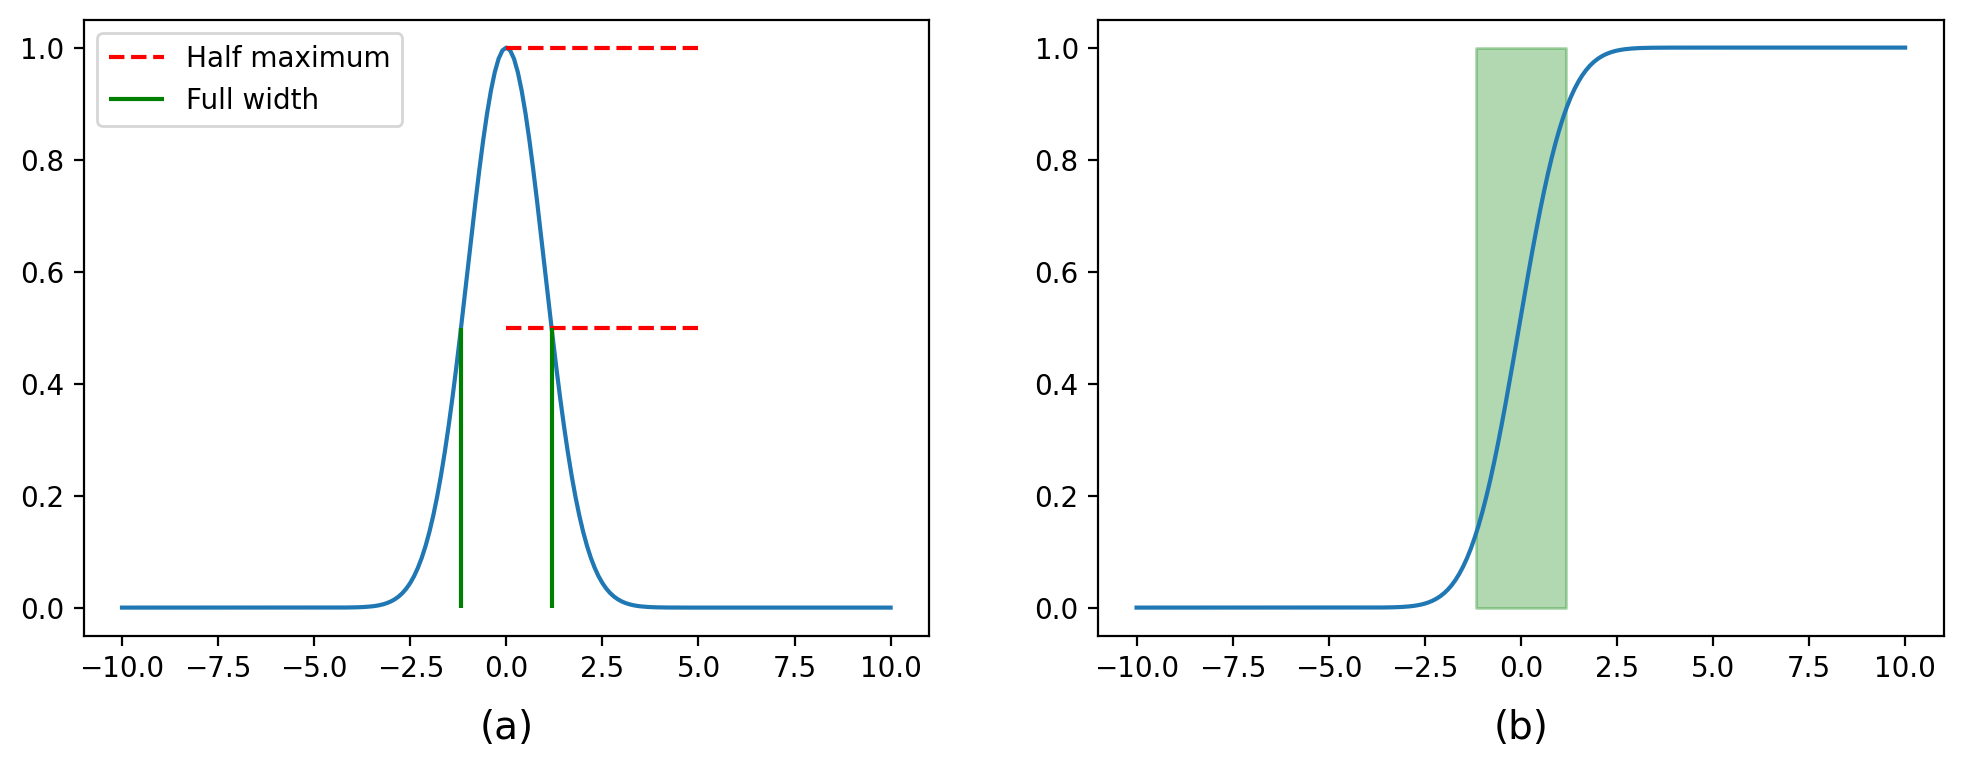

In [26]:
# Visualization
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(x,np.exp(-x**2/2))
ax[0].hlines([0.5,1],xmin=0,xmax=5,linestyles='--',color='red',label='Half maximum')

ax[0].vlines([-hw,hw],ymin=0,ymax=0.5,color='green',label='Full width')
ax[0].legend(loc='upper left')
ax[1].plot(x,np.cumsum(y)/y.sum())
ax[1].fill_between(x=[-hw,hw],y1=[0,0],y2=[1,1],color='green',alpha=0.3);

fontsize=14
labelposition= -0.15
# Set label for panel 1 -> (a)
ax[0].text(0.5, labelposition, '(a)', transform=ax[0].transAxes, fontsize=fontsize, ha='center',va='center')  

# Set label for panel 2 -> (b)
ax[1].text(0.5, labelposition, '(b)', transform=ax[1].transAxes, fontsize=fontsize, ha='center',va='center') ; 

<figcaption align = "center"><b>Figure 10</b> - FWHM positions on the edge.</figcaption>
</figure>

Figure 10b shows the edge profile and the interval covered by the upper half of the linesspread function. Here, we can see that this interval mainly covers the straigt part of the edge. 

The measurement in the image gives a distance in pixels as you can see here when we measure the FWHM of the real edge image. Here, we use the parameters from the Voigt fit for the measurement. Thanks to the fitted paramenters, we get a result with sub-pixel accuracy.

In [392]:
FWHM = res.FWHM_Voigt(vc)
print("FWHM = {0:0.2f} pixels".format(FWHM))

FWHM = 3.96 pixels


This result is still measured in pixels. To get metric dimensions of the resolution, we need to multiply by the pixel size of the image. This value was determined to 0.043mm in the pixel size tutorial.

In [393]:
pixelSize = 0.043  
print("FWHM = {0:0.2f} mm".format(FWHM*pixelSize))

FWHM = 0.17 mm


## The Modulation Transfer Function (MTF)
The smoothed line we obtained from the image is the result of the convolution between a Dirac delta function and the line spread function (LSF) which is characteristic for the imaging system. We have already used the LSF in real space to measure the resolution. An alternative view of the LSF is in the reciprocal space where the signal is plotted against the frequency instead of position. The reciprocal form of the LSF is the modulation transfer function (MTF) is used to determine the resolution in the frequency domain. The method is based in computing the Fourier transform of the line spread function, $lsf$, from the previos section in this tutorial.

$$MTF' = |\mathcal{F}\{LSF\}|$$

and normalized by the DC component, i.e. the MTF as the zero frequency - $MTF'(0)$:

$$MTF=\frac{MTF'}{MTF'(0)}$$

The transformation is done using the fast Fourier transform, FFT, which is a fast implementation for the discrete Fourier transform. The discrete nature of the FFT means some limitations; one is that the maximum frequency of the transform is limited by the Nyquist frequency. Here, we use two pixels for a period. 

The shape of the MTF is always similar for any direct imaging system, it has a maximum at the DC component and decays towards zero for higher frequencies. This is a consequence of the low pass properties of the imaging system. 



In [14]:
import numpy.fft as fft

LSF       = dp           # LSF is the derivative of the edge profile
pixelSize = 0.043        # [mm] From the pixel size tutorial
stepSize  = pixelSize/10 # we sampled the edge with 0.1 pixels 
period    = stepSize *2  # we need two pixels to describe a 
nyquist   = 1/period     # the frequency is 1/period
level     = 0.1          # Threshold for the point were we detemine the resolution, this is typically chosen as 10% 


MTF = np.abs(fft.fft(LSF))
MTF = MTF[:MTF.shape[0]//2]/MTF[0]    # We don't need the negative frequencies, let's drop that part of the spectrum.
w   = np.linspace(0,nyquist,MTF.shape[0]) # Prepare the frequency axis

# Determine the resolution
idx = np.argmax(MTF<level)

d   = (level-MTF[idx])/(MTF[idx-1]-MTF[idx])
w10 = w[idx]-d*(w[idx]-w[idx-1])         # Frequency at 10% MTF

<figure>

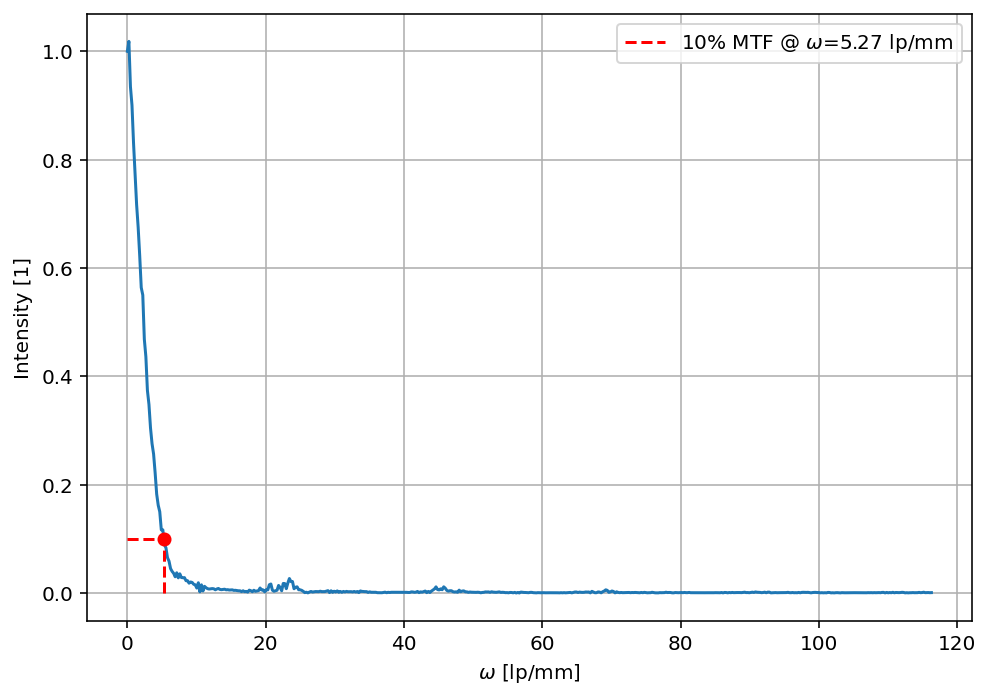

In [418]:
# Visualization
fig,ax = plt.subplots(1,figsize=(7,5))
ax.plot(w,MTF)

ax.set_xlabel('$\omega$ [lp/mm]')
ax.set_ylabel('Intensity [1]')

ax.hlines([level],xmin=w[0],xmax=w10,color='red',linestyles='--')
ax.vlines([w10],ymin=0,ymax=level,color='red',linestyles='--',label='10% MTF @ $\omega$={0:0.2f} lp/mm'.format(w10))
ax.plot(w10,level,'or')
ax.grid(visible=True)
ax.legend();
fig.tight_layout()

<figcaption align = "center"><b>Figure 11</b> - The MTF curve computed from our edge.</figcaption>
</figure>

## Comparing the methods
Comparing the results from the FWHM and MTF methods requires a conversion of the values as one is measured in real space using a metric distance and the other is measured in reciprocal space using frequencies as unit. The relation is 

$$\mbox{real space resolution} = \frac{1}{\mbox{reciprocal space resolution}}$$
Doing so, we get the following results from the two methods

|FWHM|MTF|
|--- |--- |
|0.17 mm| |

## Further methods to measure resolution
The following methods are important to mention in the context of resolution measurements.

These method distinuish themselves from the previously described by also including noise in the equation. Hence, in principle, more relevant for the practical decisions setting up an experiment. They are, however, more complicated and beyond the scope of this tutorial.

### Detective quantum efficiency
As an outlook to the next level of the analysis is to include the noise in the MTF evalutation. This is done by looking at the [Detective Quantum Efficiency](https://en.wikipedia.org/wiki/Detective_quantum_efficiency) (DQE) which is defined as

$$DQE(\omega)=\frac{MTF(\omega)^2}{NPS(\omega)}$$

Where NPS is the [noise power spectrum](https://scicoding.com/calculating-power-spectral-density-in-python/) of the image. It is possible to determine the noise limited resolution using the DQE. 

### Fourier ring/shell correlation

A method that computes the correlation between two images of the same object and same exposure time. The correlation is computed in the Fourier space as
$$C(\omega_1,\omega_2) = \mathcal{F}\{a\}\cdot \mathcal{F}\{b\}^{*}$$
and then computing the sum of the intensity as function of the radius. 

This will give a function that reflects the practical resolution given noisy images. There is a point where the noise component is stronger than the power of the signal.

## Summary

- The resolution is an essential part when you want to determine the smallest items you can detect in an image. 
- It should be have a greater value than the pixel size.
- There are different ways to compute the resolution:
    - Full-width-half maximum of the line spread function in real space.
    - MTF at some level in the reciprocal space.
    
Other methods exis but these are the most common to start with. 